In [248]:
# SELECT runtime { local | colab }
# runtime = 'local'

# SELECT Road Network Data { osm | estrada | combined }
road_path = 'osm'

# SELECT Population Data { facebook | worldpop | census }
pop_path = 'worldpop'

# SELECT Distance Threshold in KM
distance_thresholds = [20]

# SELECT potential stroke facilities { existing hospitals | grid}
potential_facilities = 'grid'

# IF potential facilties = grid, pick km's { 10 | 5 | 1 } 
grid_size = 5

# If it is grid: add the function. 
if potential_facilities == 'grid':
    if grid_size == 10:
        potential_facilities = '10kmGrid'
    elif grid_size == 5:
        potential_facilities = '5kmGrid'
    elif grid_size == 1:
        potential_facilities = '1kmGrid'

In [249]:
%%time
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px

import folium
import itertools
import geopy.distance

import warnings
warnings.filterwarnings('ignore')

import json
import time
from datetime import datetime

import sys
sys.path.append(r'../Scripts')
data_path = (r'../../Vietnam project/0906Data/')

# Import python functions
from optimization_model import OptimizationModel
from distance_matrix import DistanceCalculation, haversine_vectorize
from network_gpbp import get_nodes_and_edges
from InputDataPreprocessingv1 import CurrentHospitals, NewHospitals, NewHospitalsGrid, NewHospitalsCSV, Population, PopulationFB
from Visualization_GPBP import ParetoCurve, CreateMap

Wall time: 2.01 ms


# Import data

In [250]:
%%time
# Preprocessing of the road network
# nodes, edges_attr, network = get_nodes_and_edges(r'C:/Users/joyce/WorldBank/Vietnam Project/0906Data/road_osm_preprocessed.geojson')
nodes, edges_attr, network = get_nodes_and_edges(data_path + 'road_osm_preprocessed.geojson')

Wall time: 1min 51s


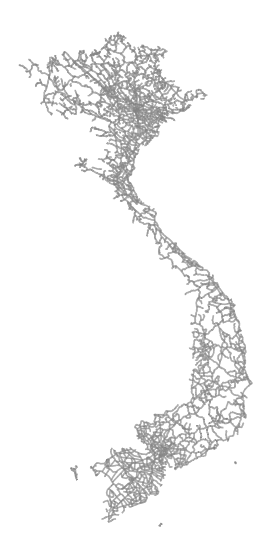

In [251]:
#Plot
f, ax = plt.subplots(figsize=(10, 10))
edges_attr.plot(ax=ax, color='grey', zorder=1)
ax.set_axis_off()
plt.show()

In [252]:
%%time
# Current Hospitals -- stroke facilities in this case
health_facilities =  pd.read_csv(data_path+'stroke-facs.csv').reset_index()
# health_facilities =  pd.read_csv(r'C:/Users/joyce/WorldBank/Vietnam Project/0906Data/stroke-facs.csv').reset_index()
health_facilities = health_facilities[['index','longitude','latitude','Name_English']]
current_hospitals_ID, current_hospitals = CurrentHospitals(health_facilities, network, nodes)

len(current_hospitals)

Wall time: 55.5 ms


80

In [253]:
%%time
# Location of new potential hospitals. 
# Pick "1kmGrid", "5kmGrid", "10kmGrid" or "existing hospitals"

if potential_facilities == "1kmGrid":
    grid = gpd.read_file(data_path+'potential_location_grid_1.geojson')
    new_hospitals_ID, new_hospitals = NewHospitalsGrid(current_hospitals, grid, network, nodes)
elif potential_facilities == "5kmGrid":
    grid = gpd.read_file(data_path+'potential_location_grid_5.geojson')
    new_hospitals_ID, new_hospitals = NewHospitalsGrid(current_hospitals, grid, network, nodes)
elif potential_facilities == "10kmGrid":
    grid = gpd.read_file(data_path+'potential_location_grid_10.geojson')
    new_hospitals_ID, new_hospitals = NewHospitalsGrid(current_hospitals, grid, network, nodes)
elif potential_facilities == "existing hospitals":
    hospitals = gpd.read_file(data_path+'hospitals_vietnam.geojson')
#     hospitals = gpd.read_file(r'C:/Users/joyce/WorldBank/Vietnam Project/0906Data/hospitals_vietnam.geojson')
    new_hospitals_ID, new_hospitals = NewHospitals(current_hospitals, hospitals, network, nodes)
else: print("Pick 1kmGrid, 5kmGrid, 10kmGrid or ExistingHospitals")

len(new_hospitals)


Wall time: 3.14 s


14235

In [254]:
%%time

# Population Data
#Round the coordinates to cluster the population. 8 digits: no rounding
digits_rounding = 2

if pop_path == 'facebook':
    read_population = pd.read_csv(data_path+'pop_fb_2020.csv').reset_index()
#     read_population = pd.read_csv(r'C:/Users/joyce/WorldBank/Vietnam Project/0906Data/pop_fb_2020.csv').reset_index()
    read_population = read_population[['index','longitude','latitude','population_2020']]
elif pop_path == 'worldpop':
    read_population = pd.read_csv(data_path+'WorldPop_2020_1km.csv').reset_index()
#     read_population = pd.read_csv(r'C:/Users/joyce/WorldBank/Vietnam Project/0906Data/WorldPop_2020_1km.csv').reset_index()
    
array_household, population = PopulationFB(digits_rounding, read_population, network, nodes)

len(population)

Wall time: 1.74 s


283557

# Distance matrix calculation

In [255]:
# Determine the smallest and largest threshold
distance_threshold_largest = max(distance_thresholds)
distance_threshold_smallest = min(distance_thresholds)

In [256]:
%%time
# Calculate distance from households to current hospitals
pop_subset = population[['nearest_node','xcoord','ycoord']]
matrix_current = DistanceCalculation(network, current_hospitals, population, pop_subset, distance_threshold_largest)
matrix_current = matrix_current[['ID','pop_dist_road_estrada','household_count','xcoord','ycoord',
                                 'Hosp_ID','hosp_dist_road_estrada','Longitude','Latitude',
                                 'shortest_path_length','euclidean_distance','total_network_distance', 'distance_corrected']]
matrix_current = matrix_current.rename(columns={'ID':'Pop_ID'})


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Wall time: 7.95 s


In [257]:
%%time
# Create a subset of the population. 
# This subset contains only the population that is not already within a range of S kilometers
withinSkm = matrix_current[matrix_current.total_network_distance<=distance_threshold_smallest]
withinSkm=withinSkm['Pop_ID'].unique()
population_new = population.drop(population[population.ID.isin(withinSkm)].index.tolist())

Wall time: 63.9 ms


In [258]:
%%time
# Calculate distance to new hospitals
pop_subset = population_new[['nearest_node','xcoord','ycoord']]
matrix_new = DistanceCalculation(network, new_hospitals, population, pop_subset, distance_threshold_largest)
matrix_new = matrix_new[['ID','pop_dist_road_estrada','household_count','xcoord','ycoord',
                                 'Cluster_ID','hosp_dist_road_estrada','Longitude','Latitude',
                                 'shortest_path_length','euclidean_distance','total_network_distance', 'distance_corrected']]
matrix_new = matrix_new.rename(columns={'ID':'Pop_ID'})

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Wall time: 20min 32s


# Optimization 

In [259]:
%%time
# Add matrix with distances of new hospitals to matrix of distances of current hospitals
matrix_new1 = matrix_new[['Pop_ID','Cluster_ID','distance_corrected']]
matrix_current1 = matrix_current[['Pop_ID','Hosp_ID','distance_corrected']]
matrix_new1.columns = ['Pop_ID','HospCluster','distance']
matrix_current1.columns = ['Pop_ID','HospCluster','distance']
df_combined = pd.concat([matrix_current1, matrix_new1],axis=0)
df_combined= df_combined.sort_values(by='Pop_ID')

Wall time: 2.56 s


# Model




$\textrm{Maximize } \quad \sum_i v_iy_i $ 

$\textrm{Subject to } \quad x_j = 1 \quad \quad \quad \quad \quad\forall j = 1, ... m $

$ \quad \quad \quad \quad \quad \sum^{M}_{j=m+1} x_j \leq p  $

$ \quad \quad \quad \quad \quad y_i \leq \sum_{j|d_{ij}\leq S} x_j \quad  \forall i \in I$

$ \quad \quad \quad \quad \quad y_i, x_j \in \{0,1\} \quad \quad\forall i \in I, \forall j \in J $

where: 

- $I$ = the index set of households, or clusters of households, indexed by $i = 1, ..., n$. 

- $J$ = the index set of all healthcare sites, where indices $j = 1, ..., m$ are corresponding to the already existing healthcare facilities and indices $j = m+1, ..., M$ are corresponding to potential hospital locations

- $v_i$ = the number of people in (cluster of) household(s) $i$

- $d_{ij}$ = the travel distance from (cluster of) household(s) $i$ to hospital facility $j$

- $S$ = the maximum travel distance from a household (or cluster) to a health care facility

- $p$ = the number of additional hospitals located.

Decision variables:
$
x_j = \begin{cases} 1 & \text{ if hospital } j \text{ is opened} \\
0 & \text{ otherwise}
\end{cases} \\
$
$
y_i = \begin{cases} 1 & \text{ if there is an opened health facility within } S \\ & \text{ kilometers travel distance away from the (cluster of) household(s) } i\\
0 & \text{ otherwise}
\end{cases}
$


In [260]:
%%time
nhospitals = [10,20,30,40,50,60,70,80,90,100,150,200,250,300,400,500,750,1000]
df_combined_output = pd.DataFrame()
for each_threshold in distance_thresholds:
    opt_array, tModelling, tSolving = OptimizationModel(array_household, current_hospitals_ID, new_hospitals_ID, df_combined, each_threshold, nhospitals)
    df_opt_outputs = pd.DataFrame(opt_array)
    df_combined_output = df_combined_output.append(df_opt_outputs)
    print("Threshold distance: " + str(each_threshold))
    print("Solving time: " + str(tSolving/60) + ", modelling time: " + str(tModelling/60))
    

Threshold distance: 20
Solving time: 18.22570650180181, modelling time: 0.3258978247642517
Wall time: 18min 33s


In [1]:
df_combined_output

NameError: name 'distance_thresholds' is not defined

In [ ]:
# Print the Pareto Curve
pareto_curve = ParetoCurve(df_combined_output, current_hospitals)
pareto_curve

In [ ]:
pareto_curve.write_html('../Data/pareto.html')

In [ ]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

for each_dist in [10,20]:
    for each_hosp_added in [0,10,20,50]:
        name_file = '../Data/maps/'+str(each_dist)+'_'+str(each_hosp_added)+'_map_render'
        CreateMap(each_dist, each_hosp_added, population, current_hospitals, new_hospitals, df_combined, df_combined_output,name_file)
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Output Time =", current_time)